# Random Forest

In [1]:
import os
import pickle
import numpy as np
import pandas as pd

import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set directories
print(os.getcwd())
dirRawData = "../rawdata/"
dirPData = "../pydata/"
dirOutput = "../output/"

/home/jovyan/work/aml_cw/code


In [3]:
def fn_MAE(actuals, predictions):
    return np.round(np.mean(np.abs(predictions - actuals)))

def fn_RMSE(actuals, predictions):
    return np.round(np.sqrt(np.mean((predictions - actuals)**2)))

In [4]:
# Load up data - df_all

f_name = dirPData + 'df_all.pickle'

with (open(f_name, "rb")) as f:
    dict_ = pickle.load(f)

df_all = dict_['df_all']

del f_name, dict_

In [5]:
# load the variables information
f_name = dirPData + 'variables.pickle'
with open(f_name, "rb") as f:
    dict_ = pickle.load(f)
    
var_dep = dict_['var_dep']
vars_ind_numeric = dict_['vars_ind_numeric']
vars_ind_categorical = dict_['vars_ind_categorical']

del dict_

In [6]:
df_test = pd.read_csv(dirRawData + 'test.csv')

In [7]:
idx_train  = df_all['fold'].isin(range(6))
idx_val    = df_all['fold'].isin([6, 7])
idx_design = df_all['fold'].isin(range(8))
idx_test   = df_all['fold'].isin([8, 9])

y = df_all[var_dep].values.ravel()
y_train = y[idx_train]
y_val = y[idx_val]
y_design = y[idx_design]
y_test = y[idx_test]

In [8]:
vars_ind = vars_ind_categorical + vars_ind_numeric

In [9]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_212"; OpenJDK Runtime Environment (build 1.8.0_212-8u212-b03-0ubuntu1.18.04.1-b03); OpenJDK 64-Bit Server VM (build 25.212-b03, mixed mode)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpcybqfd2f
  JVM stdout: /tmp/tmpcybqfd2f/h2o_jovyan_started_from_python.out
  JVM stderr: /tmp/tmpcybqfd2f/h2o_jovyan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.4
H2O cluster version age:,27 days
H2O cluster name:,H2O_from_python_jovyan_6msoil
H2O cluster total nodes:,1
H2O cluster free memory:,444.5 Mb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [10]:
h2o_df_all = h2o.H2OFrame(df_all[vars_ind + var_dep + ['fold']],
                         destination_frame = 'df_all')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [11]:
idx_h2o_train  = h2o.H2OFrame(idx_train.astype('int').values)
idx_h2o_val    = h2o.H2OFrame(idx_val.astype('int').values)
idx_h2o_design = h2o.H2OFrame(idx_design.astype('int').values)
idx_h2o_test   = h2o.H2OFrame(idx_test.astype('int').values)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [12]:
h2o_df_test = h2o.H2OFrame(df_test.loc[:, df_test.columns != 'id'], destination_frame= 'df_test')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [13]:
param_v1 = {
    "model_id": 'rf_model_v1'
    ,  "ntrees" : 100
    , "max_depth" : 20
    #Row sample rate per tree (from 0.0 to 1.0). (default: ``0.6320000291``)
    , "sample_rate" : 0.6
    #col_sample_rate_per_tree: column sampling rate for each tree (without replacement)
    , "col_sample_rate_per_tree" : 0.9
    #mtries is applied AFTER col_sample_rate_per_tree
    #, "mtries" : -1
    #, "min_rows" : 10
    # beware of default min split improvement if using imbalanced classes
    #, min_split_improvement
    , "seed": 2019
    , "score_each_iteration": True
    , "score_tree_interval": 1
    , "stopping_metric": 'mae'
    , "stopping_rounds": 2
}

In [14]:
rf_model_v1 = H2ORandomForestEstimator(**param_v1)

In [15]:
rf_model_v1.train(x=vars_ind, 
            y='target',
            training_frame=h2o_df_all[idx_h2o_train, :],
            validation_frame=h2o_df_all[idx_h2o_val, :]
            )

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [16]:
rf_model_v1

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_model_v1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.09869811862403592
RMSE: 0.31416256719099417
MAE: 0.13085632421378796
RMSLE: 0.22315818430386042
Mean Residual Deviance: 0.09869811862403592

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.0723722416037774
RMSE: 0.2690208943628309
MAE: 0.13031549622079772
RMSLE: 0.1945311647143813
Mean Residual Deviance: 0.0723722416037774
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2019-06-25 11:16:17,0.030 sec,0.0,nan,nan,nan,nan,nan,nan
,2019-06-25 11:16:18,0.733 sec,1.0,0.3569886,0.1318047,0.1274408,0.3518578,0.1277665,0.1238039
,2019-06-25 11:16:18,0.987 sec,2.0,0.3401525,0.1277550,0.1157037,0.2995669,0.1280752,0.0897403
,2019-06-25 11:16:18,1.180 sec,3.0,0.3322172,0.1292749,0.1103683,0.2850127,0.1283890,0.0812322
,2019-06-25 11:16:18,1.333 sec,4.0,0.3273443,0.1326773,0.1071543,0.2755598,0.1303275,0.0759332
,2019-06-25 11:16:19,1.500 sec,5.0,0.3141626,0.1308563,0.0986981,0.2690209,0.1303155,0.0723722


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
v_num_86,157.9953613,1.0,0.0886876
v_num_28,58.7430687,0.3718025,0.0329743
v_num_61,55.8922615,0.3537589,0.0313740
v_char_57,52.8359680,0.3344147,0.0296584
v_char_61,50.0644493,0.3168729,0.0281027
---,---,---,---
v_num_25,0.0,0.0,0.0
v_num_71,0.0,0.0,0.0
v_num_74,0.0,0.0,0.0
v_num_94,0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [17]:
h2o.no_progress()

pred_train = .predict(h2o_df_all[idx_h2o_train, :])
pred_val   = model.predict(h2o_df_all[idx_h2o_val, :])
pred_test  = model.predict(h2o_df_all[idx_h2o_test, :])

pred_train = pred_train.as_data_frame().values.ravel()
pred_val   = pred_val.as_data_frame().values.ravel()
pred_test  = pred_test.as_data_frame().values.ravel()

print('train error', fn_MAE(y[idx_train], pred_train))
print('val error',   fn_MAE(y[idx_val],   pred_val))
print('test error',  fn_MAE(y[idx_test],  pred_test))

h2o.show_progress()

NameError: name 'model' is not defined

In [55]:
print('train error', fn_RMSE(y[idx_train], pred_train))
print('val error',   fn_RMSE(y[idx_val],   pred_val))
print('test error',  fn_RMSE(y[idx_test],  pred_test))

train error 0.0
val error 0.0
test error 0.0


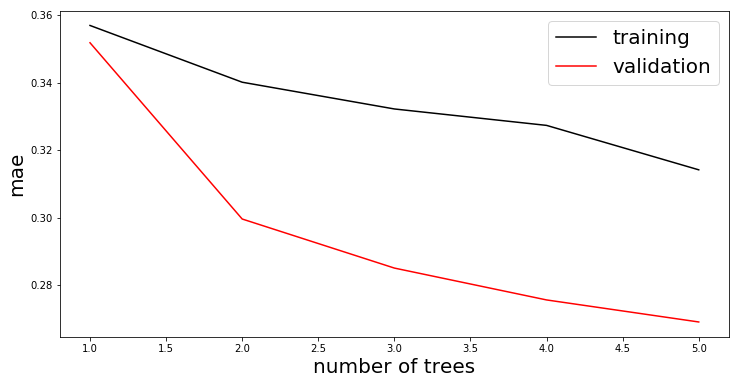

In [18]:
df1_scoring_history = rf_model_v1.scoring_history()

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df1_scoring_history['number_of_trees'],
         df1_scoring_history['training_rmse'], 'k-',
         label='training')
ax1.plot(df1_scoring_history['number_of_trees'],
         df1_scoring_history['validation_rmse'], 'r-',
        label='validation')
ax1.set_xlabel('number of trees', fontsize=20)
ax1.set_ylabel('mae', fontsize=20)
ax1.legend(fontsize=20)

In [19]:
param_v2 = {
      "ntrees" : 400
    , "max_depth" : 30
    #Row sample rate per tree (from 0.0 to 1.0). (default: ``0.6320000291``)
    , "sample_rate" : 0.6
    #col_sample_rate_per_tree: column sampling rate for each tree (without replacement)
    , "col_sample_rate_per_tree" : 0.9
    #mtries is applied AFTER col_sample_rate_per_tree
    #, "mtries" : -1
    #, "min_rows" : 10
    # beware of default min split improvement if using imbalanced classes
    #, min_split_improvement
    , "seed": 2019
    , "score_each_iteration": True
    , "score_tree_interval": 1
    , "stopping_metric": 'rmse'
    , "stopping_rounds": 20
}

In [20]:
rf_model_v2 = H2ORandomForestEstimator(**param_v2)



In [21]:
rf_model_v2.train(x=vars_ind, 
            y='target',
            training_frame=h2o_df_all[idx_h2o_train, :],
            validation_frame=h2o_df_all[idx_h2o_val, :]
            )

In [22]:
rf_model_v2

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1561461344646_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.06269640559910432
RMSE: 0.25039250308087163
MAE: 0.13207975287801704
RMSLE: 0.17660621906989132
Mean Residual Deviance: 0.06269640559910432

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.05924165502213585
RMSE: 0.24339608670259236
MAE: 0.13101811613476694
RMSLE: 0.17244917189772666
Mean Residual Deviance: 0.05924165502213585
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2019-06-25 11:17:09,0.001 sec,0.0,nan,nan,nan,nan,nan,nan
,2019-06-25 11:17:09,0.249 sec,1.0,0.3674259,0.1350018,0.1350018,0.3598987,0.1295271,0.1295271
,2019-06-25 11:17:09,0.415 sec,2.0,0.3466726,0.1286271,0.1201819,0.3040698,0.1286749,0.0924585
,2019-06-25 11:17:09,0.626 sec,3.0,0.3378631,0.1304786,0.1141515,0.2866798,0.1281068,0.0821853
,2019-06-25 11:17:09,0.793 sec,4.0,0.3310880,0.1334948,0.1096192,0.2767438,0.1301662,0.0765871
---,---,---,---,---,---,---,---,---,---
,2019-06-25 11:17:24,15.649 sec,92.0,0.2508184,0.1321847,0.0629099,0.2437750,0.1311673,0.0594262
,2019-06-25 11:17:24,15.837 sec,93.0,0.2507888,0.1321362,0.0628950,0.2436470,0.1310822,0.0593639
,2019-06-25 11:17:25,16.043 sec,94.0,0.2506804,0.1321776,0.0628406,0.2435884,0.1310634,0.0593353
,2019-06-25 11:17:25,16.222 sec,95.0,0.2505181,0.1321132,0.0627593,0.2434309,0.1309800,0.0592586



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
v_num_86,2779.5729980,1.0,0.0788844
v_char_57,1257.0070801,0.4522303,0.0356739
v_char_61,1029.0042725,0.3702023,0.0292032
v_num_61,992.6141357,0.3571103,0.0281704
v_num_28,968.6441650,0.3484867,0.0274902
---,---,---,---
v_char_15,0.0,0.0,0.0
v_char_25,0.0,0.0,0.0
v_char_40,0.0,0.0,0.0
v_char_117,0.0,0.0,0.0



See the whole table with table.as_data_frame()


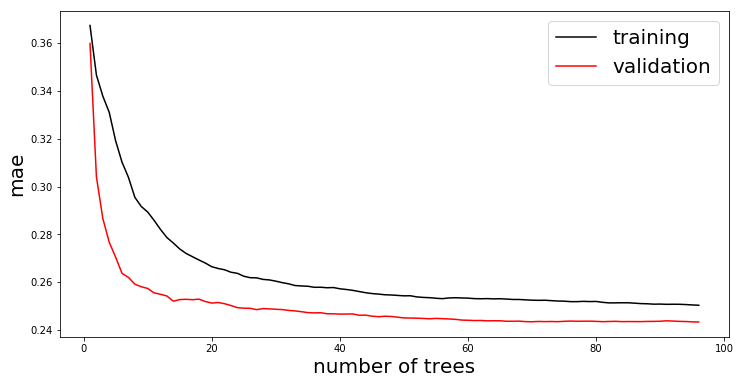

In [23]:
df2_scoring_history = rf_model_v2.scoring_history()

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df2_scoring_history['number_of_trees'],
         df2_scoring_history['training_rmse'], 'k-',
         label='training')
ax1.plot(df2_scoring_history['number_of_trees'],
         df2_scoring_history['validation_rmse'], 'r-',
        label='validation')
ax1.set_xlabel('number of trees', fontsize=20)
ax1.set_ylabel('mae', fontsize=20)
ax1.legend(fontsize=20)

In [76]:
 df_scoring_history

,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2019-06-24 14:55:00,0.008 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-06-24 14:55:00,0.313 sec,1.0,0.367426,0.135002,0.135002,0.359899,0.129527,0.129527
2,,2019-06-24 14:55:01,0.563 sec,2.0,0.346673,0.128627,0.120182,0.304070,0.128675,0.092458
3,,2019-06-24 14:55:01,0.769 sec,3.0,0.337863,0.130479,0.114151,0.286680,0.128107,0.082185
4,,2019-06-24 14:55:01,1.003 sec,4.0,0.331088,0.133495,0.109619,0.276744,0.130166,0.076587
5,,2019-06-24 14:55:01,1.291 sec,5.0,0.319151,0.132027,0.101858,0.270482,0.130614,0.073160
6,,2019-06-24 14:55:02,1.556 sec,6.0,0.310202,0.131409,0.096225,0.263711,0.129225,0.069544
7,,2019-06-24 14:55:02,1.849 sec,7.0,0.303881,0.131559,0.092343,0.262050,0.131095,0.068670
8,,2019-06-24 14:55:02,2.107 sec,8.0,0.295531,0.129219,0.087339,0.259205,0.130367,0.067187
9,,2019-06-24 14:55:03,2.408 sec,9.0,0.291703,0.130053,0.085091,0.258128,0.130652,0.066630


In [24]:
testing_df = rf_model_v2.predict(test_data= h2o_df_test).as_data_frame()

/opt/conda/lib/python3.7/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'v_char_27' has levels not trained on: [g]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'v_char_39' has levels not trained on: [S]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'v_char_100' has levels not trained on: [X, t]
  warnings.warn(w)


In [25]:
test_df = df_all[idx_test]
test_df.drop(vars_ind, axis=1, inplace=True)
test_df.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,id,target,fold
0,1,0,8
3,4,1,8
5,7,0,8
9,14,0,8
16,24,1,8


In [26]:
cominded = test_df.join(testing_df)
cominded.drop(['fold'], axis=1, inplace =True)
cominded.head(20)

,id,target,predict
0,1,0,0.052083
3,4,1,0.177399
5,7,0,0.072936
9,14,0,0.072936
16,24,1,0.041667
34,51,0,0.406720
36,53,0,0.020833
37,54,0,0.010417
45,68,1,0.010417
50,77,0,0.020833


In [27]:
cominded['roundedpred'] = cominded['predict'].round()

In [217]:
cominded.sum()

id             20818143.0
target              229.0
predict              94.5
roundedpred          32.0
dtype: float64

In [30]:
testing_df.shape

(5121, 1)

In [160]:
df_test.head()

,id,v_char_1,v_char_2,v_char_3,v_char_4,v_char_5,v_char_6,v_char_7,v_char_8,v_char_9,...,v_num_101,v_num_102,v_num_103,v_num_104,v_num_105,v_num_106,v_num_107,v_num_108,v_num_109,v_num_110
0,5,G,I,L,S,Q,L,Q,h,I,...,0,6,0,7,1,0,1,0,2,14
1,10,G,Q,q,S,Q,i,V,h,A,...,0,4,1,1,4,0,1,1,10,1
2,11,G,O,q,S,Q,i,Q,h,Y,...,0,6,0,2,1,0,1,0,18,12
3,13,G,I,q,S,Q,i,Q,d,I,...,0,8,0,1,5,0,1,0,1,2
4,16,G,V,q,S,Q,K,Q,h,Y,...,0,6,0,12,1,0,1,0,18,18


In [31]:
df_predictions = pd.DataFrame(df_test.id)

In [37]:
df_predictions = df_predictions.join(testing_df)

In [42]:
df_predictions.columns = ['id', 'target']
df_predictions.head()

,id,target
0,5,0.052083
1,10,0.187500
2,11,0.145833
3,13,0.177399
4,16,0.011210


In [43]:
df_predictions.to_csv(dirOutput+ 'rfprob.csv', index=False)